In [1]:
from yaml import safe_load
from core.data.unimers import UnimersData

data_hparams = safe_load(open("/remote/gpu04/hummerich/mol-fff/mol-fff/config/unimers_autoencoder.yaml"))[
    "data_hparams"
]
data = UnimersData(UnimersData.hparams_schema.from_dict(data_hparams))

/remote/gpu04/hummerich/mol-fff/.venv/lib/python3.11/site-packages/torch_geometric/data/dataset.py:240: UserWarning: The `pre_transform` argument differs from the one used in the pre-processed version of this dataset. If you want to make use of another pre-processing technique, pass `force_reload=True` explicitly to reload the dataset.
  warnings.warn(


In [19]:
from typing import Literal

import torch
from torch import nn, Tensor


from torch_geometric.data import Data, Batch
from torch_geometric.utils import unbatch
from torch_geometric import nn as gnn

from hydrantic.model import Model, ModelHparams
from hydrantic.hparams import Hparam

from core.models.cross_modality_ae import CrossModalityAE
from core.components.set_rff import RFF
from core.components.set_attention import SAB
from core.utils.masking import pad_sets, unpad_sets
from core.utils.graphs import dense_edge_index
from core.utils.molecules import get_molecule_from_data
from core.utils.sets import length_encoding
from core.metrics.molecules import Validity, Components, Uniqueness


class PermutationEquivariantLayer(nn.Module):
    def __init__(
        self,
        input_dim: int,
        output_dim: int,
        hidden_dim: int,
        heads: int,
        mlp_widths: list[int],
    ):
        super().__init__()
        self.state_update = RFF(2 * hidden_dim, hidden_dim, mlp_widths, activation="torch.nn.ELU")
        self.interaction_sab = SAB(input_dim + hidden_dim, hidden_dim, heads)
        self.observation = RFF(hidden_dim, output_dim, mlp_widths, activation="torch.nn.ELU")

    def forward(self, x: Tensor, s: Tensor, lengths: Tensor) -> tuple[Tensor, Tensor]:
        m = self.interaction_sab(torch.concat((s, x), dim=-1), lengths)
        x = x + self.observation(m, lengths)
        s = self.state_update(torch.concat((s, m), dim=-1), lengths)
        return x, s


class PermutationEquivariantNet(nn.Module):
    def __init__(
        self,
        dim: int,
        hidden_dim: int,
        heads: int,
        mlp_widths: list[int],
        num_layers: int = 1,
    ):
        super().__init__()
        self.layers = nn.ModuleList(
            [PermutationEquivariantLayer(dim, dim, hidden_dim, heads, mlp_widths) for _ in range(num_layers)]
        )

    def forward(self, x: Tensor, s: Tensor, lengths: Tensor) -> Tensor:
        for layer in self.layers:
            x, s = layer(x, s, lengths)
        return x


class NodeEmbeddingFMHparams(ModelHparams):
    dim: int
    hidden_dim: int = Hparam(ge=1)
    num_bead_classes: int
    mlp_widths: list[int]
    heads: int
    num_layers: int = Hparam(ge=1)

    graph_autoencoder_ckpt: str

    latent_distribution: Literal["normal"] = "normal"


class NodeEmbeddingFM(Model):
    hparams_schema = NodeEmbeddingFMHparams
    graph_autoencoder: CrossModalityAE

    def __init__(self, hparams: NodeEmbeddingFMHparams):
        super().__init__(hparams)
        self.net = self._configure_network()
        self.bead_embedding = nn.Linear(self.hparams.num_bead_classes, self.hparams.hidden_dim)
        self.graph_autoencoder = self._configure_graph_autoencoder()

    def _configure_network(self) -> nn.Module:
        return PermutationEquivariantNet(
            self.hparams.dim,
            self.hparams.hidden_dim,
            self.hparams.heads,
            self.hparams.mlp_widths,
            self.hparams.num_layers,
        )

    def forward(self, t: Tensor, x_t: Tensor, lengths: Tensor, c: Tensor | None = None) -> Tensor:
        s = self.bead_embedding(c) if c is not None else torch.zeros(x_t.size(0), x_t.size(1), self.hparams.hidden_dim)
        s += t
        return self.net(x_t, s, lengths)

    def compute_metrics(self, batch: Batch, batch_idx):
        metrics: dict[str, Tensor] = {}
        loss_fn = nn.MSELoss(reduction="none")

        with torch.no_grad():
            x_1, lengths = self.embed(batch)

        c = batch.bead.unsqueeze(1).repeat(1, x_1.size(1), 1)

        x_0 = torch.randn_like(x_1)

        x_1.requires_grad = True
        x_0.requires_grad = True
        t = torch.rand(x_1.shape[0], 1, 1, device=x_1.device, dtype=x_1.dtype)

        x_t = (1 - t) * x_0 + t * x_1
        dx_t = x_1 - x_0

        metrics["loss"] = loss_fn(self(t, x_t, lengths, c=c), dx_t).sum(dim=-1).mean()

        return metrics

    def step(
        self,
        x_t: Tensor,
        t_start: Tensor,
        t_end: Tensor,
        lengths: Tensor,
        c: Tensor | None = None,
    ) -> Tensor:
        """Integration step between two time points.

        :param x_t: position at time t_start.
        :param t_start: start time of the integration step.
        :param t_end: end time of the integration step.
        :return: position at time t_end."""

        t_start = t_start.view(1, 1).expand(x_t.shape[0], 1, 1)

        return x_t + (t_end - t_start) * self(
            t_start + (t_end - t_start) / 2,
            x_t + self(t_start, x_t, lengths, c=c) * (t_end - t_start) / 2,
            lengths,
            c=c,
        )

    def embed(self, batch: Batch) -> tuple[Tensor, Tensor]:
        """Embeds a batch of graphs as a set of node embeddings.

        :param batch: A batch of graphs.
        :return: A batch of node embeddings and the corresponding lengths."""

        h_graph = self.graph_autoencoder.encode(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
        h_list = unbatch(h_graph, batch.batch)
        h, lengths = pad_sets(h_list)
        return h, lengths

    def reconstruct(self, h: Tensor, lengths) -> Batch:
        """Reconstructs the graph structures from a set of node embeddings.

        :param h: A batch of node embeddings.
        :param lengths: A batch of lengths.
        :return: A batch of graph structures."""

        batch_code = self.set_to_graph(h, lengths)
        x1, edge_attr1 = self.graph_autoencoder.decode(batch_code.x, batch_code.edge_index, batch_code.batch)
        batch1 = batch_code.clone()
        batch1.x = x1
        batch1.edge_attr = edge_attr1
        return batch1

    def _configure_graph_autoencoder(self) -> CrossModalityAE:
        graph_autoencoder = CrossModalityAE.load_from_checkpoint(
            self.hparams.graph_autoencoder_ckpt, map_location=self.device
        )
        graph_autoencoder = graph_autoencoder.eval()
        graph_autoencoder = graph_autoencoder.requires_grad_(False)
        graph_autoencoder.freeze()
        return graph_autoencoder

    @property
    def num_bond_classes(self) -> int:
        """Number of bond classes."""
        num_edge_classes: dict[str, int] = {
            "qm9": 5,
            "pcqm4m": 5,
            "zinc": 4,
            "unimers": 4,
        }
        return num_edge_classes[self.graph_autoencoder.hparams.profile]

    @property
    def num_atom_classes(self) -> int:
        """Number of atom classes."""
        num_atom_classes: dict[str, int] = {
            "qm9": 9,
            "pcqm4m": 36,
            "zinc": 28,
            "unimers": 4,
        }
        return num_atom_classes[self.graph_autoencoder.hparams.profile]

    def graph_to_set(self, batch: Batch) -> tuple[Tensor, Tensor]:
        """Transforms a batch of graphs to a batch of sets.

        :param batch: batch of graphs to transform
        :return: batch of sets"""

        x_list = unbatch(batch.x, batch.batch)
        x_list, lengths = pad_sets(x_list)
        return x_list, lengths

    def set_to_graph(self, x: Tensor, lengths: Tensor) -> Batch:
        """Transforms a batch of sets to a batch of fully connected graphs with empty edge attributes.

        :param x: batch of sets to transform
        :param lengths: batch of sets lengths
        :return: batch of sets"""

        x_list = unpad_sets(x, lengths)
        geom_data_list = [
            Data(
                x=x_list[i],
                edge_index=dense_edge_index(lengths[i].item(), x.device),
                edge_attr=torch.empty(
                    (lengths[i] ** 2 - lengths[i], self.num_bond_classes),
                    device=x.device,
                ),
            )
            for i in range(len(x_list))
        ]
        return Batch.from_data_list(geom_data_list)

In [28]:
model = NodeEmbeddingFM(
    NodeEmbeddingFMHparams(
        dim=10,
        hidden_dim=32,
        mlp_widths=[64],
        num_bead_classes=26,
        heads=2,
        num_layers=4,
        graph_autoencoder_ckpt="/remote/gpu04/hummerich/mol-fff/mol-fff/lightning_logs/Selected Models/CrossModalityAE.ckpt",
    )
)

model = model.fit_fast(data.train_loader, n_epochs=100, accelerator="gpu", lr=1e-3)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type                      | Params | Mode 
------------------------------------------------------------------------
0 | net               | PermutationEquivariantNet | 57.3 K | train
1 | bead_embedding    | Linear                    | 864    | train
2 | graph_autoencoder | CrossModalityAE           | 53.7 K | eval 
------------------------------------------------------------------------
58.1 K    Trainable params
53.7 K    Non-trainable params
111 K     Total params
0.447     Total estimated model params size (MB)
103       Modules in train mode
174       Modules in eval mode


Epoch 12:  24%|██▎       | 274/1156 [00:05<00:17, 51.86it/s, training/loss=9.050] 


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [29]:
batch = next(iter(data.train_loader))
batch_size = batch.num_graphs
with torch.no_grad():
    x = torch.randn(batch_size, 9, 10)
    lengths = torch.ones(batch_size, dtype=torch.long) * 9

    n_steps = 101
    time_steps = torch.linspace(0, 2.0, n_steps + 1)
    traj = [x]
    for i in range(n_steps):
        x = model.step(x_t=x, t_start=time_steps[i], t_end=time_steps[i + 1], lengths=lengths, c=batch.bead.unsqueeze(1).repeat(1, 9, 1))
        if i % 20 == 0:
            traj.append(x)

[09:55:05] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.


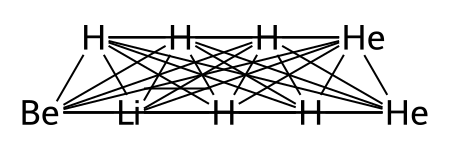

In [30]:
h = traj[-1]

batch = model.reconstruct(h, lengths)

mols = [get_molecule_from_data(batch[i].x, batch[i].edge_index, batch[i].edge_attr) for i in range(batch.num_graphs)]
mols[0]